In this simple experiment I want to replicate the Sparse Matching of DinoV2 as shown in [this page](https://dinov2.metademolab.com/demos?category=patch_matching)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# DINOv2
model: nn.Module = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

Using cache found in C:\Users\Luca/.cache\torch\hub\facebookresearch_dinov2_main


(3456, 2304)


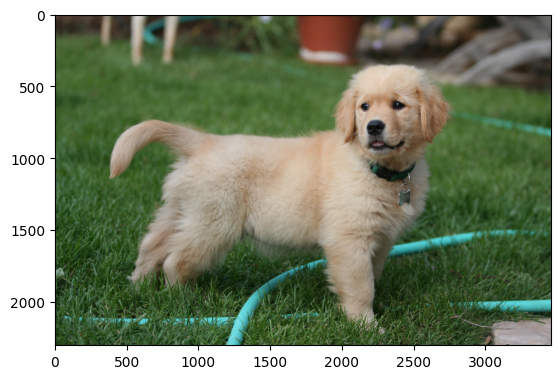

torch.Size([1, 3, 420, 420])


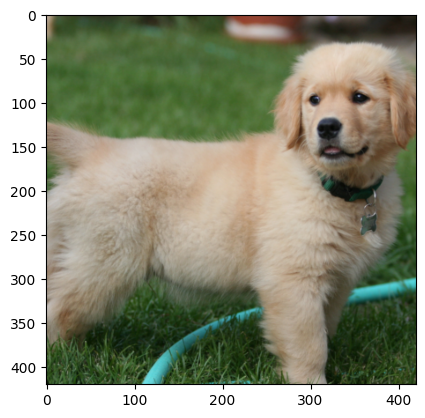

In [4]:
# Open a sample image from ImageNet
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

input_image = Image.open("test_image3.jpg")

# Preprocess the image
preprocess = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.CenterCrop(14 * 30),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)
print(input_image.size)
plt.imshow(input_image)
plt.show()
x = preprocess(input_image).unsqueeze(0)
print(x.shape)
plt.imshow(x[0].permute(1, 2, 0))
plt.show()
y = model(x)

In [54]:
type(model)

dinov2.models.vision_transformer.DinoVisionTransformer

In [10]:
def extract_features(model, image, show_image=False):
    # Preprocess the image
    preprocess = transforms.Compose(
        [
            transforms.Resize(512),
            transforms.CenterCrop(14 * 30),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ]
    )
    x = preprocess(image).unsqueeze(0)
    
    if show_image:
        plt.imshow(x[0].permute(1, 2, 0))
        plt.show()
    
    y = model(x, is_training=True)
    features = y["x_norm_patchtokens"]
    return features

input_image = Image.open("test_image3.jpg")
extract_features(model, input_image).shape

torch.Size([1, 900, 384])

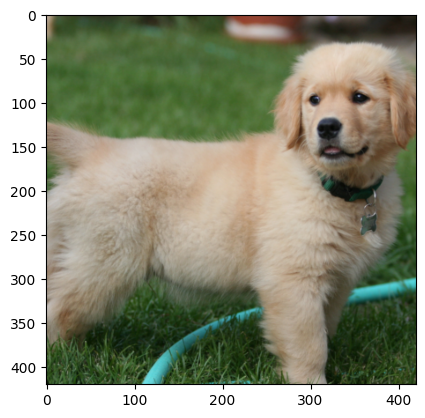

(900, 3)


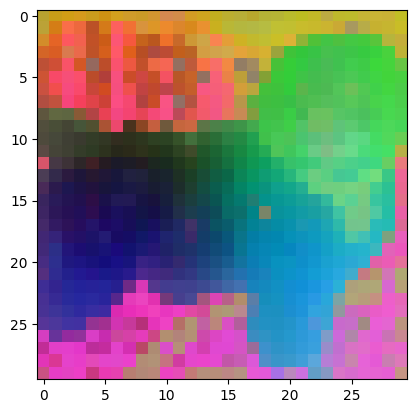

In [40]:
def plot_PCA(features):
    # Apply PCA to the last dimension of y
    from sklearn.decomposition import PCA
    import numpy as np
    from tqdm import tqdm

    pca = PCA(n_components=3)
    H, W = 30, 30
    result_image = np.zeros((H, W, 3))
    # for n in tqdm(range(num_patches)):
    patch_color = pca.fit_transform(features[0].detach().numpy())
    patch_color = (patch_color - patch_color.min()) / (
        patch_color.max() - patch_color.min()
    )
    print(patch_color.shape)

    for i in range(H):
        for j in range(W):
            n = i * H + j
            result_image[i, j] = patch_color[n]

    result_image = result_image.reshape(H, W, 3)
    plt.imshow(result_image)
    plt.show()
  
plot_PCA(extract_features(model, input_image, show_image=True))

In [41]:
def compare_features(y1, y2):
    # y1.shape = (1, num_patches_1, 384)
    # y2.shape = (1, num_patches_2, 384)
    # output: (num_patches_1, num_patches_2)
    
    # Calculate the similarity between each pair of patches
    y1 = y1.squeeze(0) # (num_patches_1, 384)
    y2 = y2.squeeze(0) # (num_patches_2, 384)
    
    y1_normalized = F.normalize(y1, p=2, dim=1)
    y2_normalized = F.normalize(y2, p=2, dim=1)
    
    similarity = y1_normalized @ y2_normalized.T
    
    return similarity

input_image1 = Image.open("test_image.jpg")
input_image2 = Image.open("test_image3.jpg")

features1 = extract_features(model, input_image1)
features2 = extract_features(model, input_image2)

similarity = compare_features(features1, features2)    

(array([368, 124, 458, 368, 668, 519, 668, 458, 519, 241, 118, 118,  64,
       241, 124, 124, 241, 368, 458, 668, 668, 368, 519, 118, 278],
      dtype=int64), array([221, 124, 221, 131, 131, 221, 221, 131, 131, 124, 131, 221, 124,
       221, 131, 221, 131, 124, 163, 163, 124, 163, 163, 163, 221],
      dtype=int64))


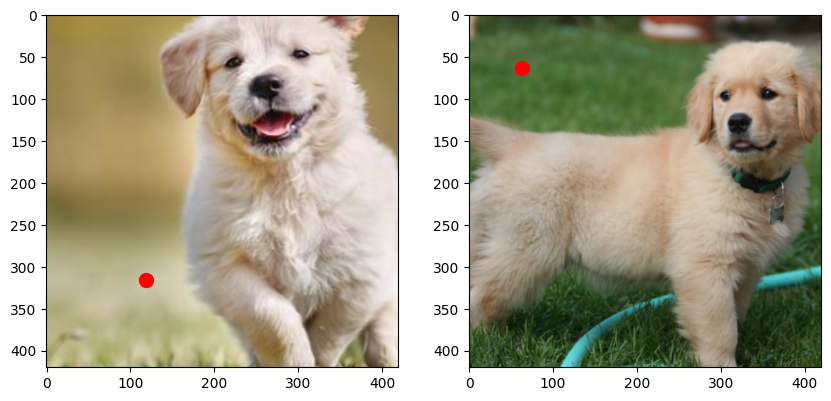

tensor(0.9517, grad_fn=<DotBackward0>)
(315, 119) (63, 63)


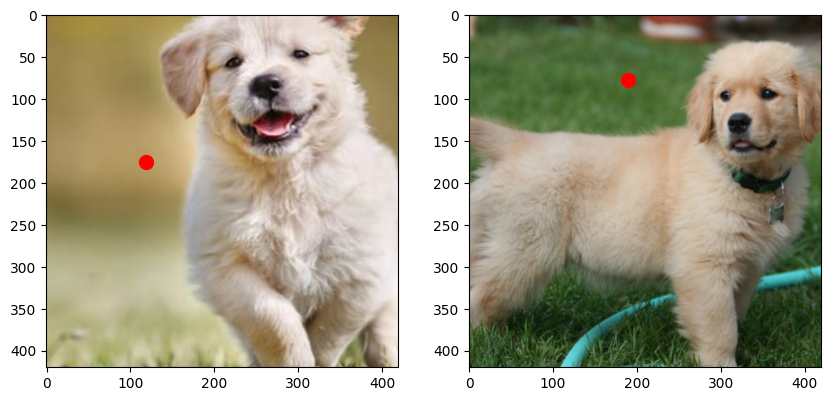

tensor(0.9515, grad_fn=<DotBackward0>)
(175, 119) (77, 189)


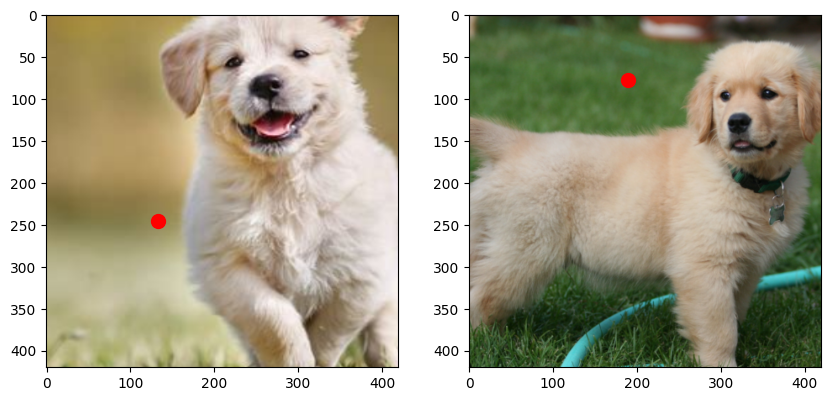

tensor(0.9511, grad_fn=<DotBackward0>)
(245, 133) (77, 189)


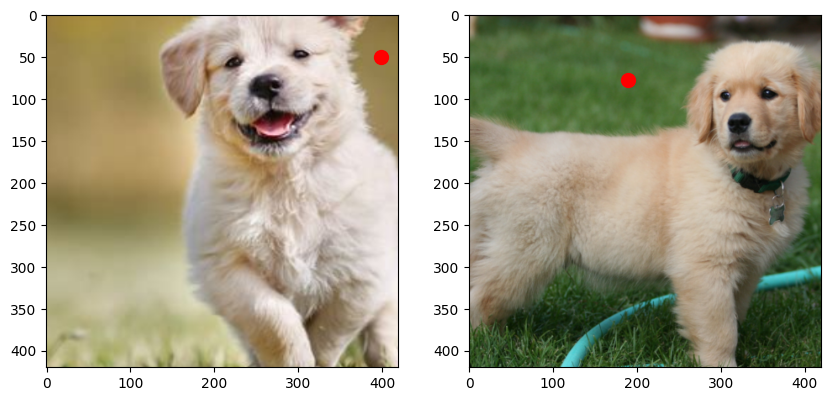

tensor(0.9504, grad_fn=<DotBackward0>)
(49, 399) (77, 189)


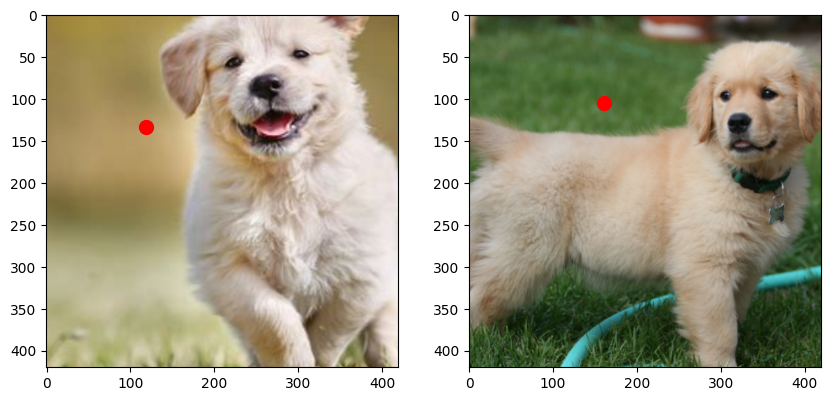

tensor(0.9502, grad_fn=<DotBackward0>)
(133, 119) (105, 161)


In [51]:
def from_patch_coord_to_pixel_coord(patch_coord: tuple[int, int], patch_size=14):
    return (patch_coord[0] * patch_size) + patch_size // 2, (patch_coord[1] * patch_size) + patch_size // 2

# Select the top 5 most similar patches
import numpy as np

preprocess = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.CenterCrop(14 * 30),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

top_k = 25
top_indices = torch.topk(similarity.flatten(), top_k).indices
top_indices = np.unravel_index(top_indices, similarity.shape)
print(top_indices)

for k in range(20, top_k):
    y_1_index = np.unravel_index(top_indices[0][k], (30, 30))
    y_2_index = np.unravel_index(top_indices[1][k], (30, 30))
    
    y_1_index = from_patch_coord_to_pixel_coord(y_1_index)
    y_2_index = from_patch_coord_to_pixel_coord(y_2_index)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(preprocess(input_image1).permute(1,2,0))
    plt.scatter(y_1_index[1], y_1_index[0], color="red", s=100)
    
    plt.subplot(1, 2, 2)
    plt.imshow(preprocess(input_image2).permute(1,2,0))
    plt.scatter(y_2_index[1], y_2_index[0], color="red", s=100)
    plt.show()
    
    
    # plot_PCA(features1)
    # plot_PCA(features2)
    
    norm_feat_1 = F.normalize(features1[0][top_indices[0][k]], p=2, dim=0)
    norm_feat_2 = F.normalize(features2[0][top_indices[1][k]], p=2, dim=0) 
    print(norm_feat_1 @ norm_feat_2.T)
    
    print(y_1_index, y_2_index)